# Media Mix Modeling with Carryover and Saturation Effects Using Bayesian Methods

This is a reference implementation of a Bayesian model for channel attribution. The design of the model can be summarized as follows:
* We assume a company that runs promotion and advertising activities using several marketing channels.
* For each channel $i$, we observe a time series $x_{it}$ that corresponds to channel activity/intensity (e.g. spend).
* We also observe the outcome time series $y_t$ that corresponds to the number of conversions, site visits, etc.
* We assume that the relationship model between the channel activity and the outcome needs to account for the follwoing effects: 
* * Channel activity generally follows the law of diminishing returns. This can be modeled using some nonlinear saturation function $s(x_t)$.
* * Channel activity at time $t$ can have delayed or long-lasting effects on outcomes $y_{t+1}, y_{t+2}, \ldots$. This carryover effect can be modeled using a filter (convolution operation) $c(x)$.

The above assumptions result into the following model specification $y = \sum_{i} c(s(x_i))$

### References
[1] Jin Y., Wang Y., Sun Y., Chan D., Koehler J. -- Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects, 2017

# Step 1: Generate Data Sample

We start with implementing a customizable data generator that can be parametrized by link functions that specify saturation and carryover effects. 

Running on PyMC3 v3.9.3


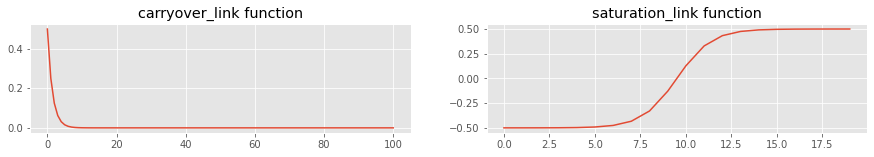

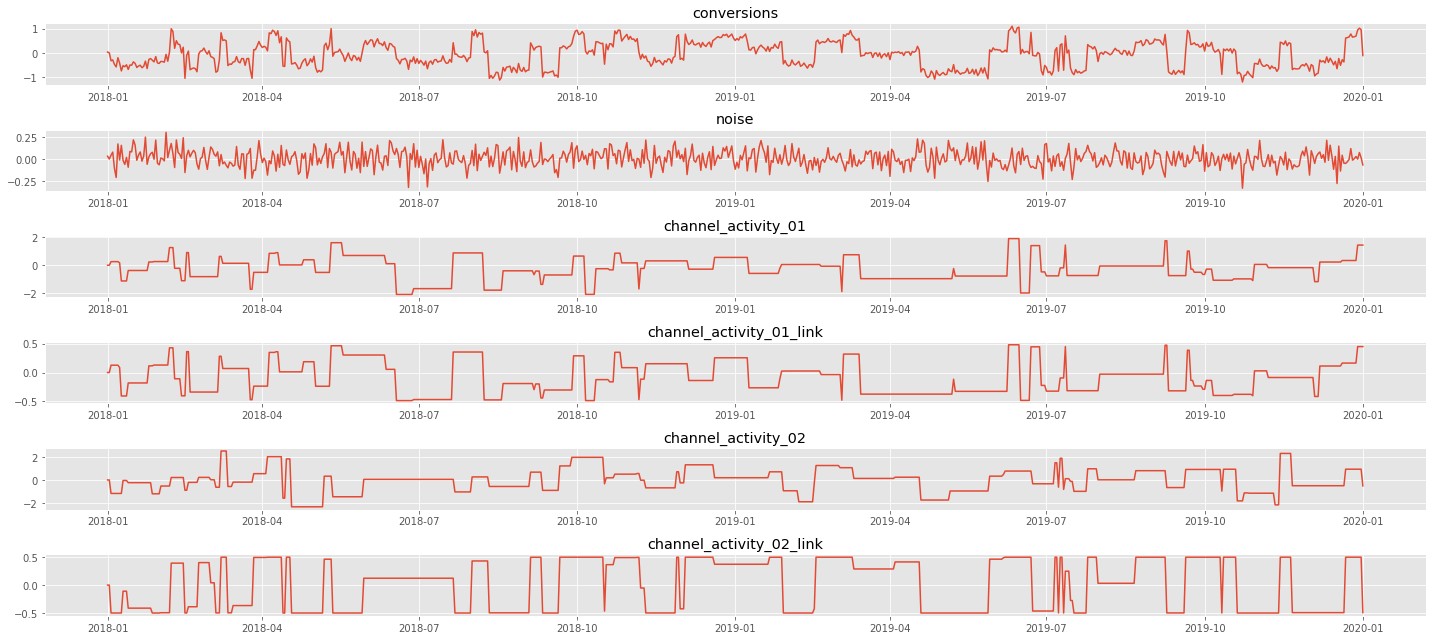

In [936]:
import pymc3 as pm
from pymc3 import  *
import theano
import theano.tensor as tt
print('Running on PyMC3 v{}'.format(pm.__version__))

import numpy as np
import pandas as pd
import datetime
import collections
import functools
import math
from matplotlib import pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None
    
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

def linear_link(x, scale = 1, mean = 0):
    return scale * x + mean

def saturation_link(x, alpha = 1, beta = 1):
    return alpha * (1 / (1 + np.exp(-beta*x)) - 0.5)

def carryover_link(x, k = 0.5, l = 30):
    # we use exponential decay weights w_t ~ exp(k^t)
    # another reasonable alternative is gaussian weights w_t ~ exp(-(t-t_0)^2)
    w = np.array([ np.power(k, i) for i in range(l) ])
    xx = np.vstack([ np.append(np.zeros(i), x[:len(x)-i]) for i in range(l) ])
    y = np.dot(w/np.sum(w), xx)
    return y

def saturation_and_carryover_link(x, alpha, beta, k):
    x_sat = saturation_link(x, alpha, beta)
    return carryover_link(x_sat, k)

def create_mediamix_data(links = [saturation_link, carryover_link]):
    days_year = 365
    quaters_year = 4
    days_week = 7
    
    # two years of data, daily resolution
    idx = pd.date_range(start='2018-01-01', end='2020-01-01', freq='D') 

    df = pd.DataFrame(index=idx, dtype=float)
    df = df.fillna(0.0)
    
    n = len(df.index)
    
    channel_activity = [step_series(n, 0, 1.0, 80), step_series(n, 0, 1.0, 80)]
    channel_activity_links = [ links[i](channel_activity[i]) for i in range(len(links)) ]
    
    noise = 0.1 * np.random.randn(n)
    
    conversions = np.sum(channel_activity_links, axis=0) + noise
    
    df['conversions'], df['noise'] = conversions, noise
    for i in range(len(links)):
        df[f'channel_activity_0{i+1}'] = channel_activity[i]
        df[f'channel_activity_0{i+1}_link'] = channel_activity_links[i]
    
    return df

#
# preview link functions
#
fig, ax = plt.subplots(1, 2, figsize=(15, 2))
impulse = np.append([1], np.zeros(100))
ax[0].plot(carryover_link(impulse))
ax[0].set_title('carryover_link function')
ax[1].plot(saturation_link(np.linspace(-1, 1, 20), alpha=1, beta=10))
ax[1].set_title('saturation_link function')

#
# link functions
#
num_channels = 2    # number of media channels (covariates)

# Linear model
true_lin_param = {'intercept': [0.0, 3.0], 'alpha': [1.0, 2.0]}
links_linear = [functools.partial(linear_link, 
                                  scale=true_lin_param['alpha'][i], 
                                  mean=true_lin_param['intercept'][i]) for i in range(num_channels)] 

# Saturation model
true_sat_param = {'beta': [2.0, 10.0], 'alpha': [1.0, 1.0]}
links_saturation = [functools.partial(saturation_link, 
                                      alpha=true_sat_param['alpha'][i], 
                                      beta=true_sat_param['beta'][i]) for i in range(num_channels)] 

# Carryover model
true_car_param = {'k': [0.2, 0.8]}
links_carryover = [functools.partial(carryover_link, 
                                     k=true_car_param['k'][i]) for i in range(num_channels)] 

# Saturation and carryover (SC) model
true_sc_param = {'alpha': [1.0, 1.0], 'beta': [2.0, 10.0], 'k': [0.2, 0.8]}
links_sc = [functools.partial(saturation_and_carryover_link, 
                              alpha=true_sc_param['alpha'][i], 
                              beta=true_sc_param['beta'][i], 
                              k=true_sc_param['k'][i]) for i in range(num_channels)] 

def plot_media_data(df):
    fig, ax = plt.subplots(len(df.columns), figsize=(20, len(df.columns)*1.5))
    for i, c in enumerate(df.columns):
        ax[i].plot(df.index, df[c])
        ax[i].set_title(c)

    plt.tight_layout()
    plt.show()
    
def training_set(df):
    x = np.float64( df[['channel_activity_01', 'channel_activity_02']].values.T )
    y = np.float64( df[['conversions']].values.T )
    return x, y

#
# preview data
#
df = create_mediamix_data(links_saturation)
plot_media_data(df)

# Step 2: Basic GLM 

In this section, we fit a basic linear model using PyMC3 using NUTS and VI.

In [590]:
df = create_mediamix_data(links=links_linear)
x, y = training_set(df)
print(f'x.shape=[{x.shape}], y.shape=[{y.shape}]')

x.shape=[(2, 731)], y.shape=[(1, 731)]


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-5.4--aws-x86_64-with-glibc2.29-x86_64-3.8.2-64/lock_dir/lock


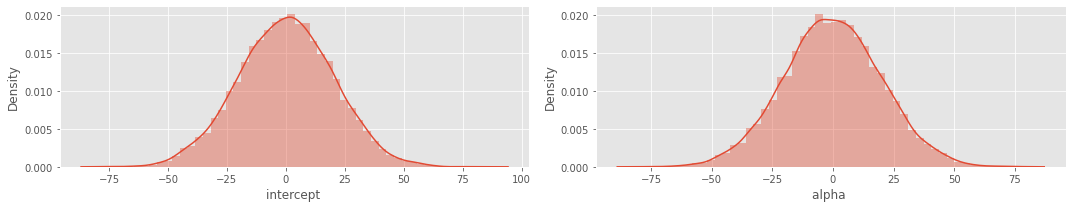

In [591]:
def plot_priors(variables):
    cols = 2
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                sns.distplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j], axlabel=f'{var.name} ')
    plt.tight_layout()

#
# Model specification
#
with Model() as model: 
    intercept = Normal('intercept', 0, sigma=20, shape=1)
    alpha = Normal('alpha', 0, sigma=20, shape=(1, num_channels))
    
    plot_priors([intercept, alpha])

    likelihood = Normal('y', mu = intercept + tt.dot(alpha, x), sigma=1, observed=y) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


True model parameters [{'intercept': [0.0, 3.0], 'alpha': [1.0, 2.0]}]


<Figure size 504x504 with 0 Axes>

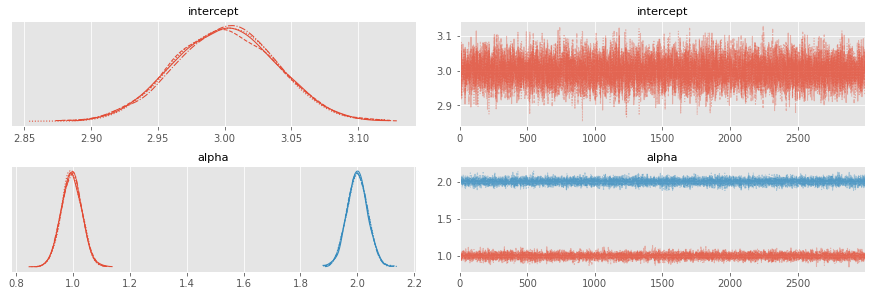

In [593]:
#
# NUTS
#
with model:    
    trace = sample(3000, cores=4)

print(f'True model parameters [{true_lin_param}]')
plt.figure(figsize=(7, 7))
with model:
    traceplot(trace)

Finished [100%]: Average Loss = 787.75


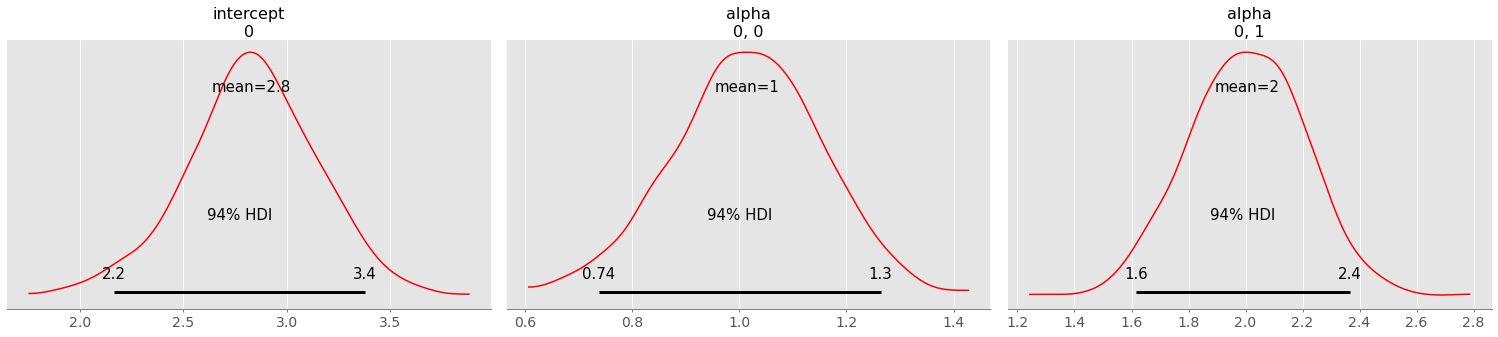

In [594]:
#
# VI
#
with model:
    vi_posterior = pm.fit(method='advi')
    pm.plot_posterior(vi_posterior.sample(1000), color='Red');

# Step 3: GML with Nonlinear Saturation

Next, we turn on the saturation effects and fit a more complex model that estimates nonlinear dependencies.  

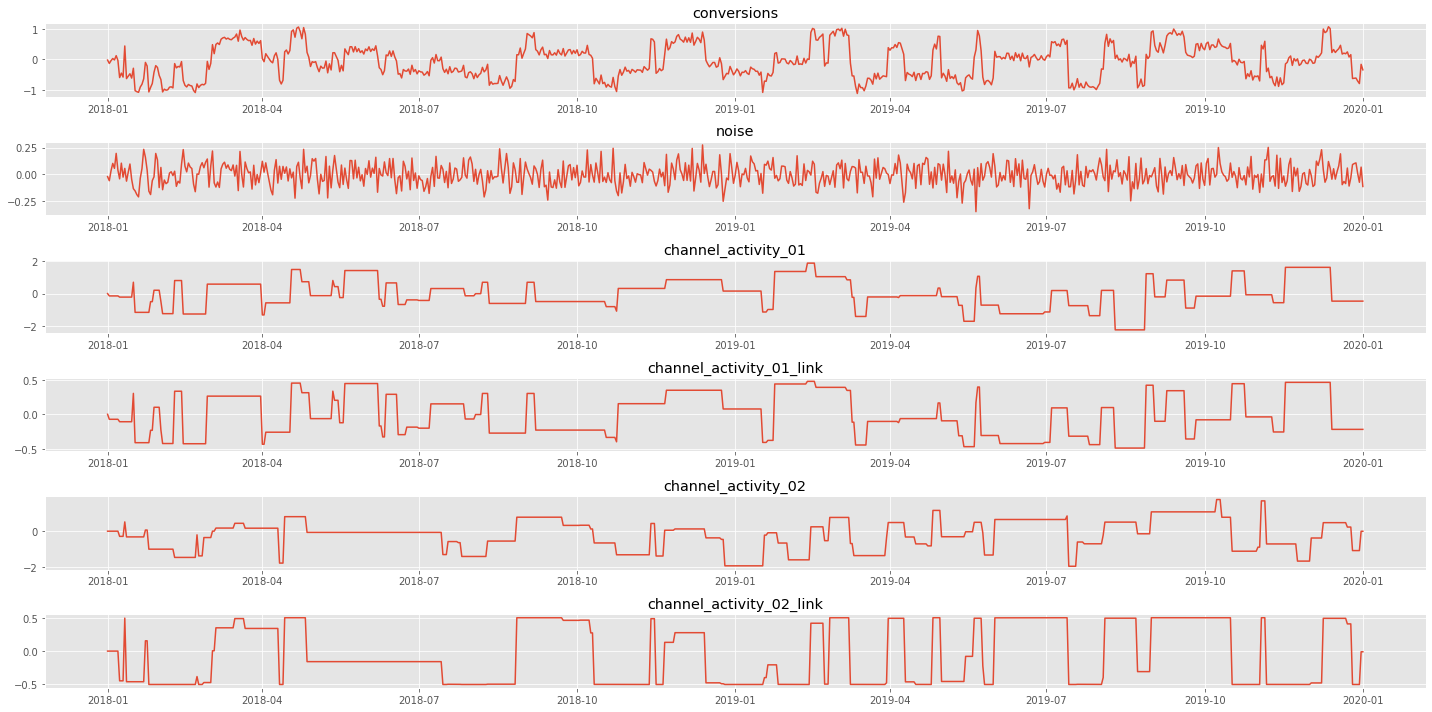

x.shape=[(2, 731)], y.shape=[(1, 731)]


In [595]:
df = create_mediamix_data(links=links_saturation)
x, y = training_set(df)
plot_media_data(df)
print(f'x.shape=[{x.shape}], y.shape=[{y.shape}]')

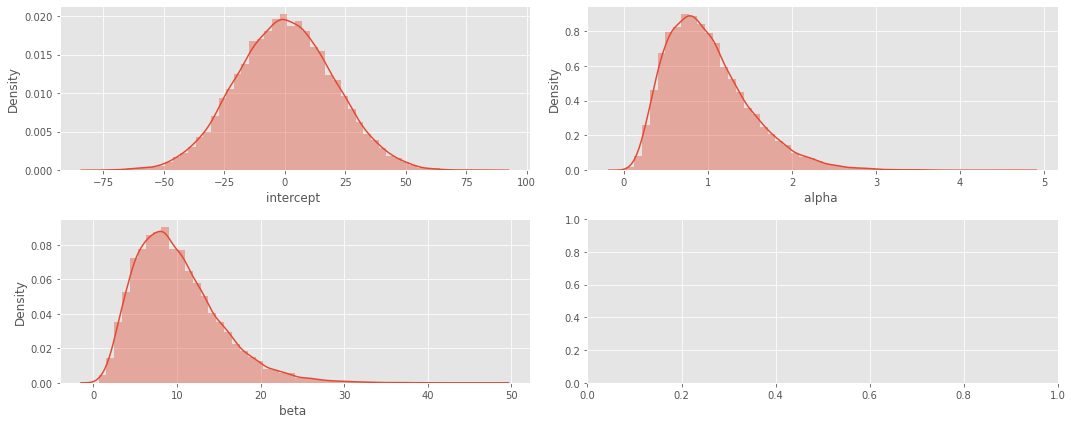

In [599]:
def saturation_link_tt(x, beta):
    return tt.nnet.sigmoid(tt.mul(beta.T, x)) - 0.5
#
# Model specification
#
with Model() as model: 
    intercept = Normal('intercept', 0, sigma=20, shape=1)
    alpha = Gamma('alpha', mu=1, sigma=0.5, shape=(1, num_channels)) # assume channels have positive contributions 
    beta = Gamma('beta', mu=10, sigma=5, shape=(1, num_channels))
    
    plot_priors([intercept, alpha, beta])

    likelihood = Normal('y', mu = intercept + tt.dot(alpha, saturation_link_tt(x, beta)), sigma=1, observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13700
Interrupted at 13,699 [6%]: Average Loss = 744.87
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


True model parameters [{'beta': [2.0, 10.0], 'alpha': [1.0, 1.0]}]


<Figure size 504x504 with 0 Axes>

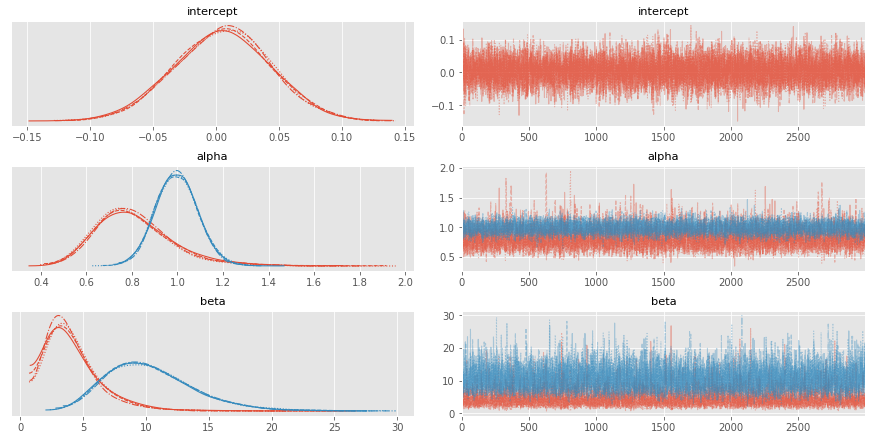

In [601]:
#
# NUTS
#
with model:    
    trace = sample(3000, cores=4, init='advi')

print(f'True model parameters [{true_sat_param}]')
plt.figure(figsize=(7, 7))
with model:
    traceplot(trace)

Finished [100%]: Average Loss = 695.16


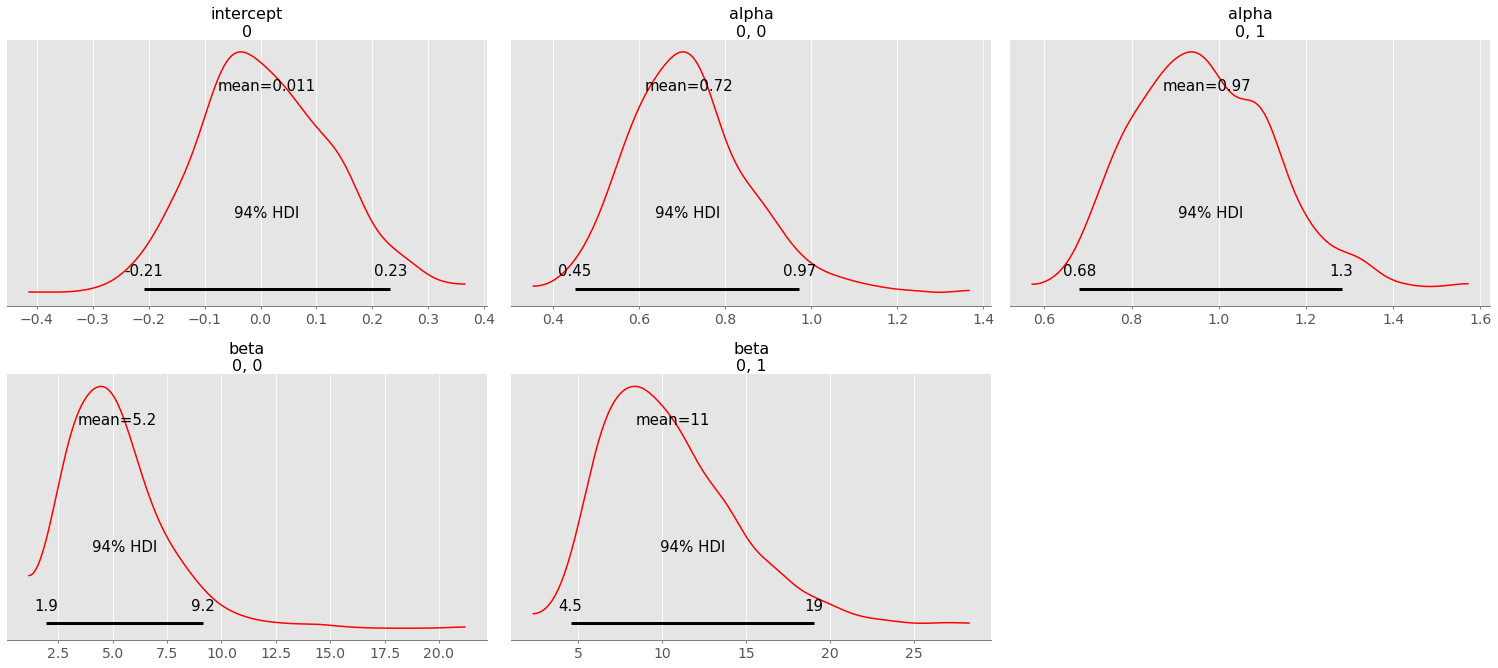

In [602]:
#
# VI
#
with model:
    vi_posterior = pm.fit(method='advi')
    pm.plot_posterior(vi_posterior.sample(1000), color='Red');

# Step 4: GLM with Carryover

Next, we explore the carryover effect and fit a model that accounts for it.

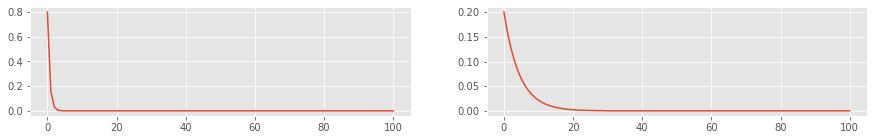

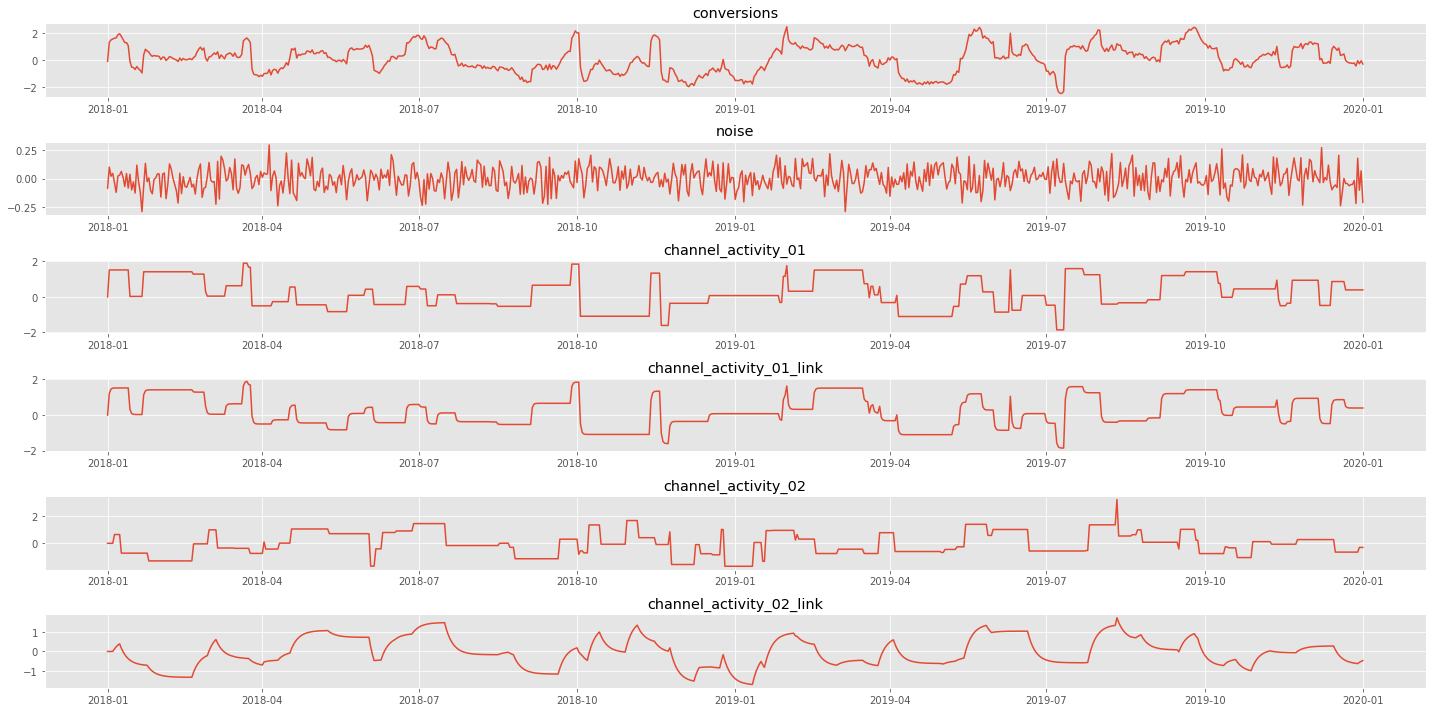

x.shape=[(2, 731)], y.shape=[(1, 731)]


In [603]:
fig, ax = plt.subplots(1, num_channels, figsize=(15, 2))
x = np.append([1], np.zeros(100))
for i in range(num_channels):
    ax[i].plot(links_carryover[i](x))

df = create_mediamix_data(links=links_carryover)
x, y = training_set(df)
plot_media_data(df)
print(f'x.shape=[{x.shape}], y.shape=[{y.shape}]')

In [605]:
def carryover_link_exp_tt(x, k = 0.5, l = 30):
    w = tt.as_tensor_variable([ tt.power(k, i) for i in range(l) ])
    xx = tt.stack([ tt.concatenate([ tt.zeros(i), x[:x.shape[0] - i] ]) for i in range(l) ])
    y = tt.dot(w/tt.sum(w), xx)
    return y

#
# Model specification
#
with Model() as model:
    k = Beta('k', mu=0.5, sigma=0.2, shape=num_channels)
    x_linked = tt.stack( [ carryover_link_exp_tt(x[i,:], k = k[i]) for i in range(num_channels) ] )
        
    intercept = Normal('intercept', 0, sigma=20, shape=1)
    alpha = Normal('alpha', 0, sigma=20, shape=(1, num_channels))

    likelihood = Normal('y', mu = intercept + tt.dot(alpha, x_linked), sigma=1, observed=y) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-5.4--aws-x86_64-with-glibc2.29-x86_64-3.8.2-64/lock_dir/lock


Convergence achieved at 15400
Interrupted at 15,399 [7%]: Average Loss = 819.68
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, intercept, k]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 57 seconds.


True model parameters [{'k': [0.2, 0.8]}]


<Figure size 504x504 with 0 Axes>

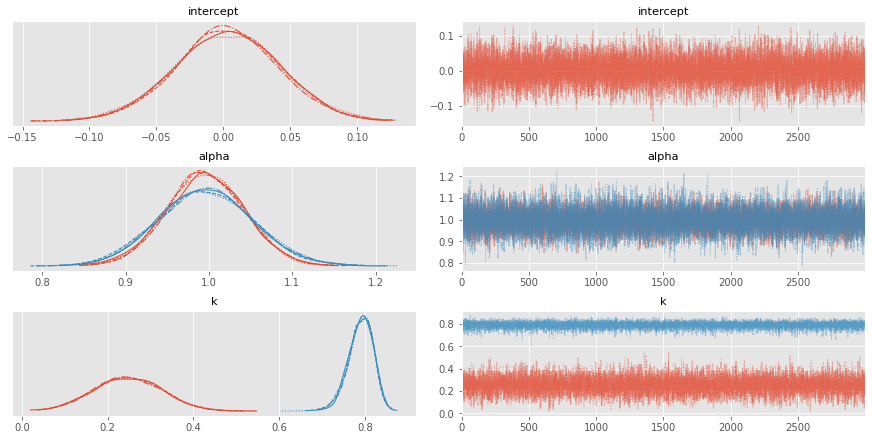

In [606]:
#
# NUTS
#
with model:    
    trace = sample(3000, cores=4, init='advi')

print(f'True model parameters [{true_car_param}]')
plt.figure(figsize=(7, 7))
with model:
    traceplot(trace)

Finished [100%]: Average Loss = 698.43


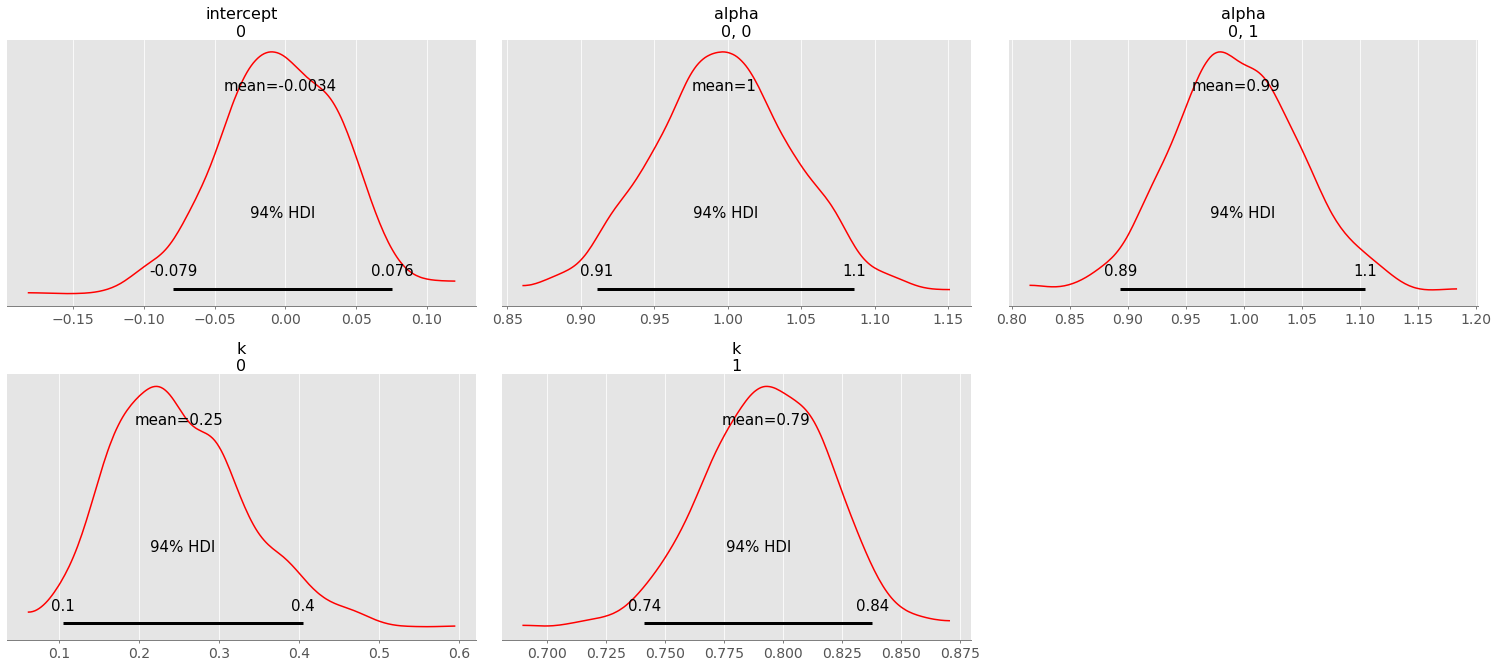

In [607]:
#
# VI
#
with model:
    vi_posterior = pm.fit(method='advi', n=100000)
    pm.plot_posterior(vi_posterior.sample(1000), color='Red');

# Step 5: GLM with Saturation and Carryover

Finally, we simultanously turn on saturation and carryover effects and fit a model that accounts for both.

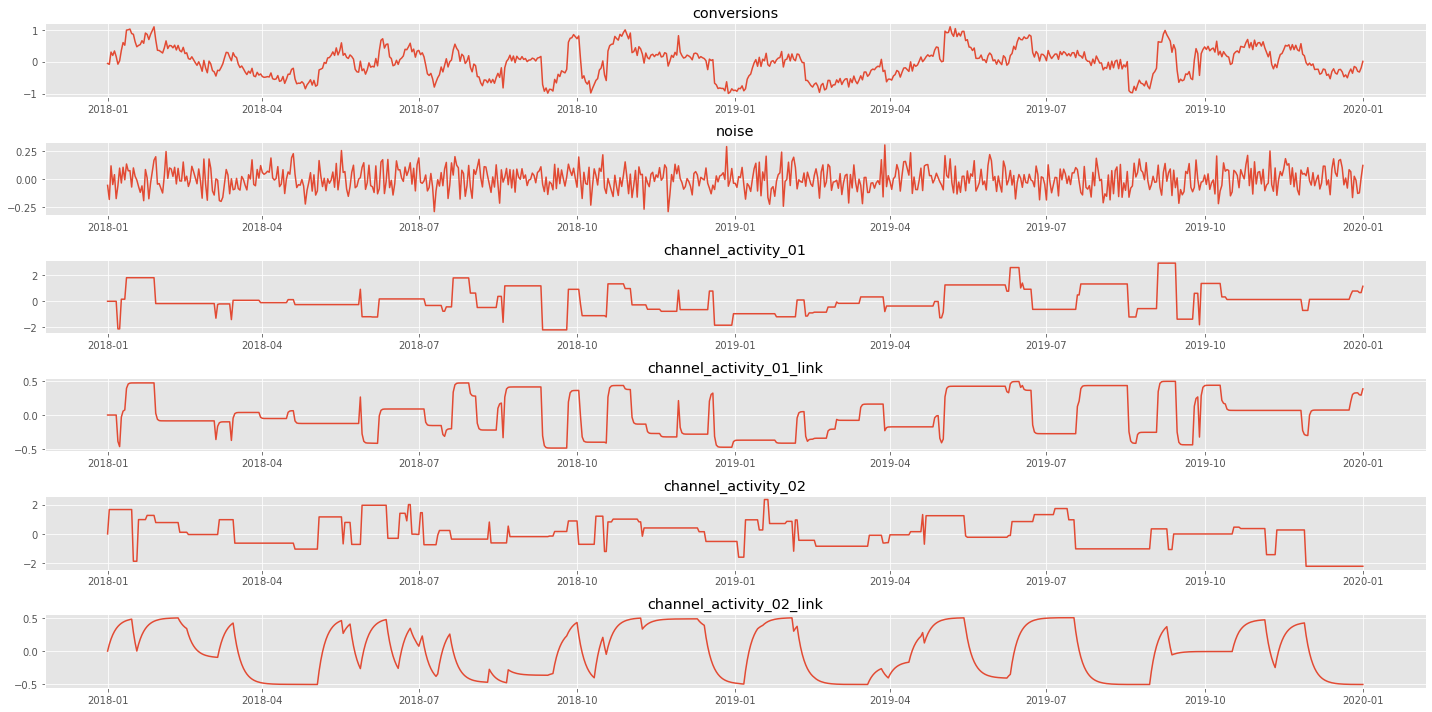

x.shape=[(2, 731)], y.shape=[(1, 731)]


In [608]:
df = create_mediamix_data(links=links_sc)
x, y = training_set(df)
plot_media_data(df)
print(f'x.shape=[{x.shape}], y.shape=[{y.shape}]')

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-5.4--aws-x86_64-with-glibc2.29-x86_64-3.8.2-64/lock_dir/lock


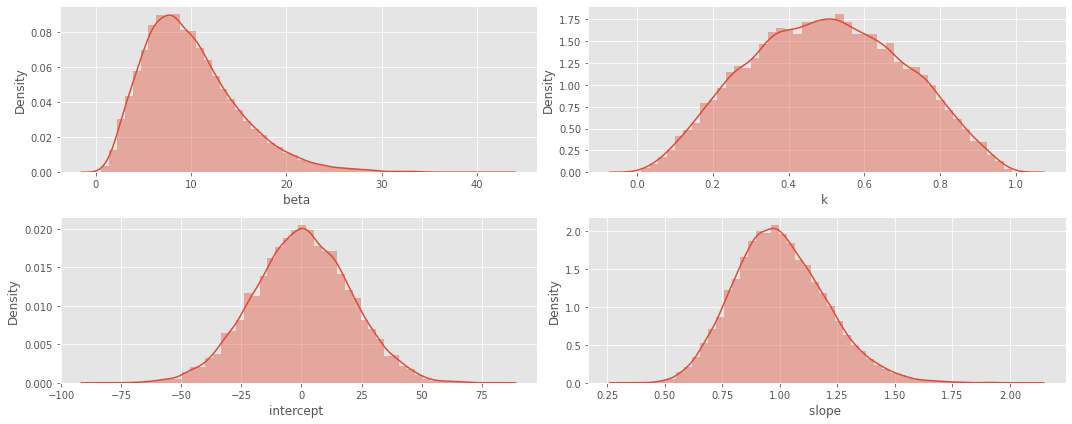

In [609]:
def saturation_link_tt(x, beta):
    return tt.nnet.sigmoid(tt.mul(beta.T, x)) - 0.5

def carryover_link_exp_tt(x, k = 0.5, l = 30):
    w = tt.as_tensor_variable([ tt.power(k, i) for i in range(l) ])
    xx = tt.stack([ tt.concatenate([ tt.zeros(i), x[:x.shape[0]-i] ]) for i in range(l) ])
    y = tt.dot(w/tt.sum(w), xx)
    return y
                
#
# Model specification:
# The covariates are first transformed using link models
# and then combined into 
#
with Model() as model: 
    # parameters and priors
    beta = Gamma('beta', mu=10, sigma=5, shape=(1, num_channels))
    k = Beta('k', mu=0.5, sigma=0.2, shape=num_channels)
    intercept = Normal('intercept', 0, sigma=20, shape=1)
    alpha = Gamma('alpha', mu=1, sigma=0.2, shape=(1, num_channels))
    
    # plot some priors
    plot_priors([beta, k, intercept, slope])
    
    # apply link models
    x_saturated = saturation_link_tt(x, beta)
    x_linked = tt.stack( [ carryover_link_exp_tt(x_saturated[i,:], k = k[i]) for i in range(num_channels) ] )
     
    # top level regression
    likelihood = Normal('y', mu = intercept + tt.dot(alpha, x_linked), sigma=1, observed=y)

True model parameters [{'alpha': [1.0, 1.0], 'beta': [2.0, 10.0], 'k': [0.2, 0.8]}]


Finished [100%]: Average Loss = 689.59
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-5.4--aws-x86_64-with-glibc2.29-x86_64-3.8.2-64/lock_dir/lock


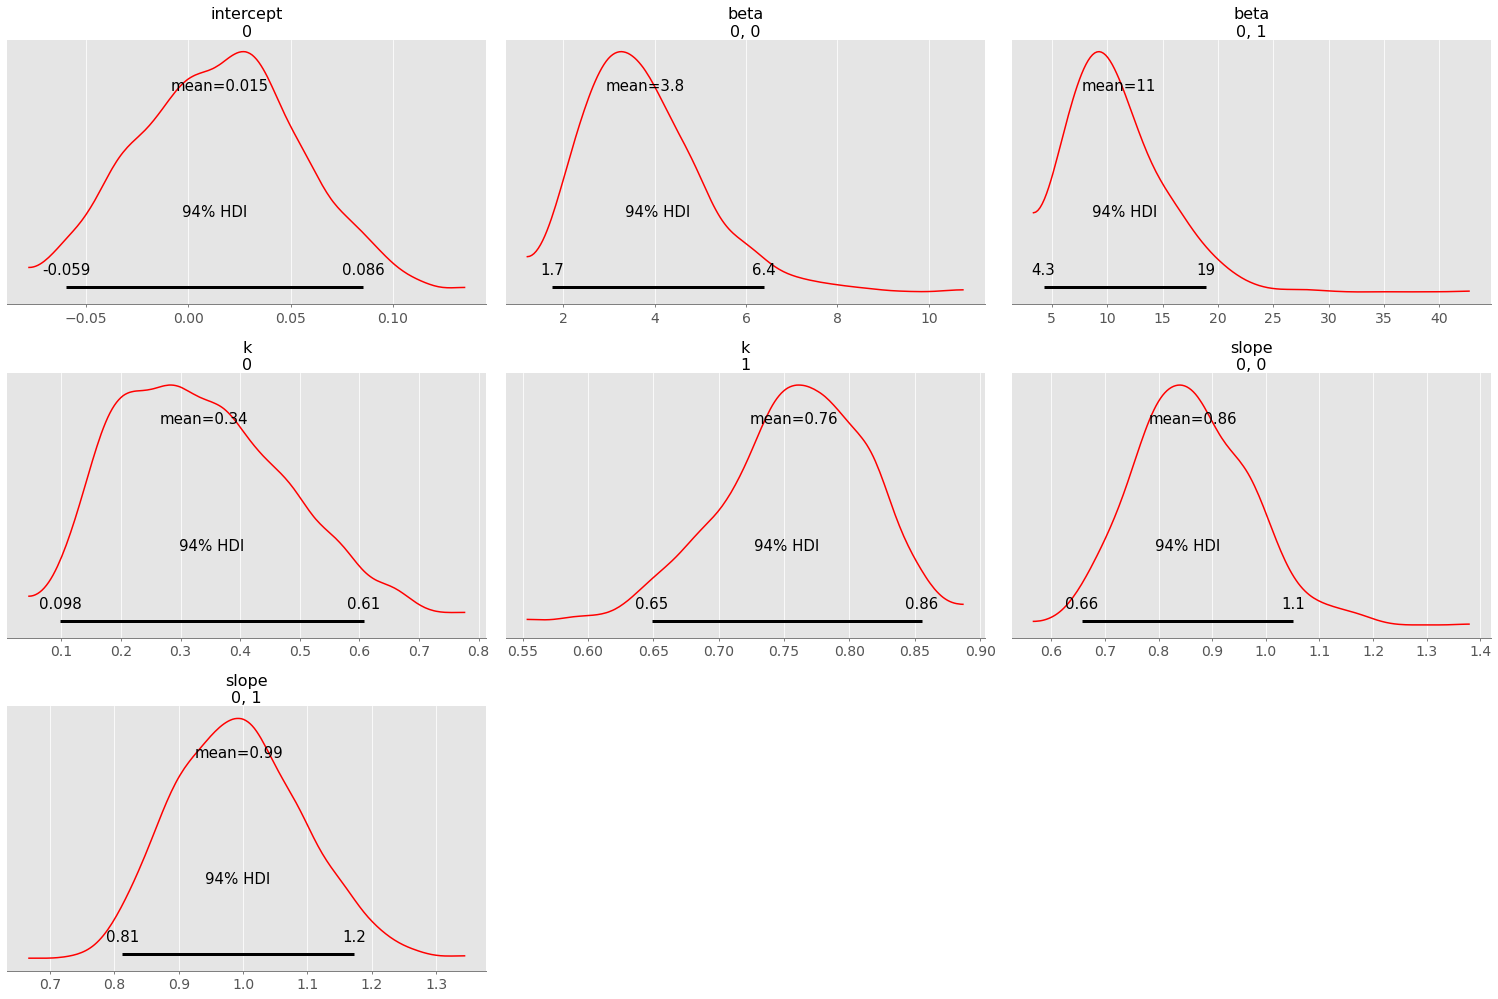

In [610]:
#
# VI
#
print(f'True model parameters [{true_sc_param}]')
with model:
    vi_posterior = pm.fit(method='advi', n=100000)
    pm.plot_posterior(vi_posterior.sample(1000), color='Red');

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 14700
Interrupted at 14,699 [7%]: Average Loss = 741.85
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-5.4--aws-x86_64-with-glibc2.29-x86_64-3.8.2-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, k, beta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 191 seconds.


True model parameters [{'alpha': [1.0, 1.0], 'beta': [2.0, 10.0], 'k': [0.2, 0.8]}]


<Figure size 504x504 with 0 Axes>

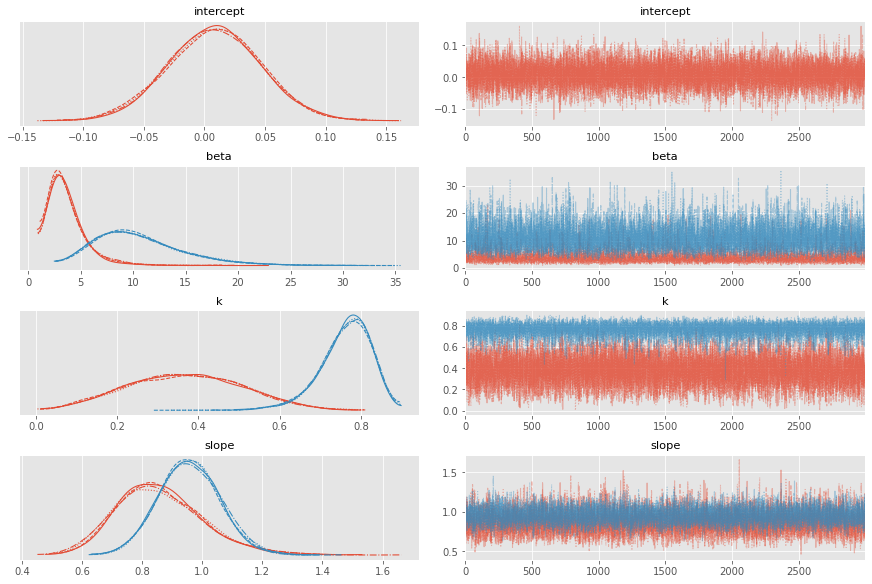

In [568]:
#
# NUTS
#
with model:    
    trace = sample(3000, cores=4, init='advi')

print(f'True model parameters [{true_sc_param}]')

plt.figure(figsize=(7, 7))
with model:
    traceplot(trace)